In [1]:
mkdir ~/.kaggle

In [2]:
!cp kaggle.json ~/.kaggle/  

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download adityajn105/flickr8k

 99% 1.02G/1.04G [00:05<00:00, 231MB/s]
100% 1.04G/1.04G [00:05<00:00, 213MB/s]


In [5]:
! mkdir working

In [6]:
! unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [7]:
import os
import pickle
from tqdm.notebook import tqdm
import numpy as np

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical, plot_model


In [8]:
 BASE_DIR = '/content'
 WORKING_DIR = '/content/working'

# Extract Image Features

In [9]:
# Load VGG model

model = VGG16()

# Restructure the model
model = Model(inputs = model.inputs, outputs = model.layers[-2].output )

# Summarize
print(model.summary())

553467096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [10]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [11]:
list(features.keys())[0]

'3265964840_5374ed9c53'

In [16]:
features['3306951622_93b82cac21']


array([[0.       , 0.       , 2.4822793, ..., 0.       , 0.       ,
        2.1509008]], dtype=float32)

In [17]:
#  Store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [18]:
#  load features fro pickle

with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
  features = pickle.load(f)
  


# Load the Captions Data

In [19]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()

In [20]:
# Create mappings of image to captions

mapping = {}

# process lines
for line in tqdm(captions_doc.split('\n')):
  # splitting the line by comma
  tokens = line.split(',')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1:]

  # remove extension from image ids
  image_id = image_id.split('.')[0]

  # convert caption list to string
  caption = " ".join(caption)

  # create list if needed
  if image_id not in mapping:
    mapping[image_id]=[]
  mapping[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [21]:
len(mapping)

8091

In [22]:
#  cleaning

def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      # take one caption at a time
      caption = captions[i]
      # preprocessing steps
      caption = caption.lower()
      # delete digits, special characters
      caption = caption.replace('[^A-Za-z]', '')
      # delete additional spaces
      caption = caption.replace('\s+', ' ')
      # add start and end tags to the caption
      caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
      captions[i] = caption




In [23]:
# before preprocessing the text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [24]:
clean(mapping)

In [25]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [26]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)
    

In [27]:
len(all_captions)

40455

In [28]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [29]:
from IPython.core.displayhook import tokenize
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [30]:
vocab_size

8485

In [31]:
# get maximum length of caption available
max_length = max(len(caption.split()) for caption in all_captions)

In [32]:
max_length

35

# Train Test split

In [33]:
from re import S
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split: ]

In [34]:
# creating a data generator to fetch the image and capitons with a set batch size for memory management
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  # loop over images
  X1, X2, y = list(), list(), list()
  n = 0

  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      # process each caption
      for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        # split  the sequence into X, y pairs
        for i in range(1, len(seq)):
          # split into input and output pairs
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen= max_length)[0]
          # encode the output sequence(one hot encoded)
          out_seq = to_categorical([out_seq], num_classes= vocab_size)[0]

          # store the sequences
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)

      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield [X1, X2], y
        X1, X2, y = list(), list(), list()
        n = 0
           



# Model Creation

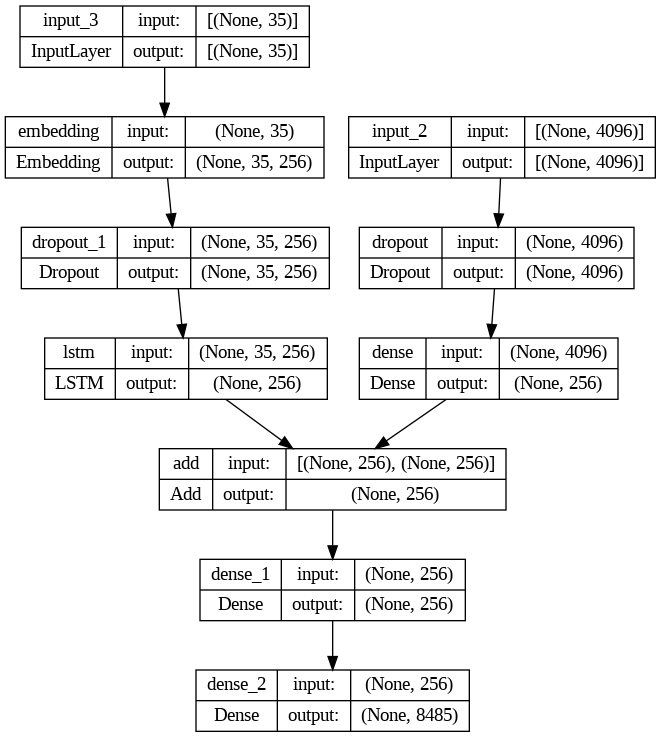

In [35]:
# Encoder Model
# Image feature layers 
inputs1 = Input(shape= (4096, ))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation= 'relu')(fe1)

# sequence feature layers
inputs2 = Input(shape= (max_length, ))
se1 = Embedding(vocab_size, 256, mask_zero= True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder Model

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation= 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'Softmax')(decoder2)

model = Model(inputs= [inputs1, inputs2], outputs= outputs)
model.compile(loss= 'categorical_crossentropy', optimizer= 'adam')

# Plot the model
plot_model(model, show_shapes= True)





# Train the model

In [36]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
  # create data generator
  generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
  # fit for on epoch
  model.fit(generator, epochs= 1, steps_per_epoch= steps, verbose= 1)



227/227 [==============================] - 66s 289ms/step - loss: 2.2093


In [37]:
# sav ethe model
model.save('best_model.h5')

# Generate Captions for the Image

In [38]:
def idex_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [39]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
  # add start tag for the generation process
  in_text = 'startseq'
  # iterate over the max length of sequences
  for i in range(max_length):
    # encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad the sequences
    sequence = pad_sequences([sequence], max_length)
    # predict the next word
    yhat = model.predict([image, sequence], verbose= 0)
    # get the index with the highest probability
    yhat = np.argmax(yhat)
    # conevrt index to word
    word = idex_to_word(yhat, tokenizer)
    # stop if word not found
    if word is None:
      break
    # append word as input for generating next word
    in_text += " " + word
    # stop if end tag
    if word == 'endseq':
      break
  return in_text


In [40]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
  # get actual captions
  captions = mapping[key]
  # predict the caption for the image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  actual.append(actual_captions)
  predicted.append(y_pred)

# Calculate n gram BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.532477
BLEU-2: 0.304522


# Visualize the Results

In [43]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
  # image_name = "1001773457_577c3a7d70.jpg"
  image_id = image_name.split('.')[0]
  img_path = os.path.join(BASE_DIR, "Images", image_name)
  image = Image.open(img_path)
  captions = mapping[image_id]
  print('-------------------Actual---------------------')
  for caption in captions:
    print(caption)
  # predict the caption
  y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
  print('-----------------Predicted--------------------')
  print(y_pred)
  plt.imshow(image)



-------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
-----------------Predicted--------------------
startseq black and white dog is running on sidewalk endseq


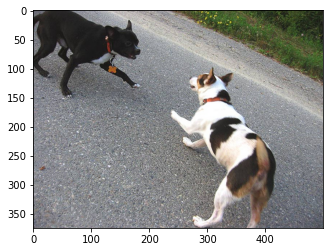

In [45]:
generate_caption('1001773457_577c3a7d70.jpg')